<a href="https://colab.research.google.com/github/umiSirya/MachineLearning_2/blob/main/daily_total_female_births_CA(Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/daily-total-female-births-CA.csv')
df.head()

,date,births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


**EDA**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    365 non-null    object
 1   births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
df.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


**Data Cleaning**

In [ ]:
# convert date dtype into datetime
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   births  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [ ]:
# setting the month column to index
df = df.set_index('date')
df.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


**Visualization**

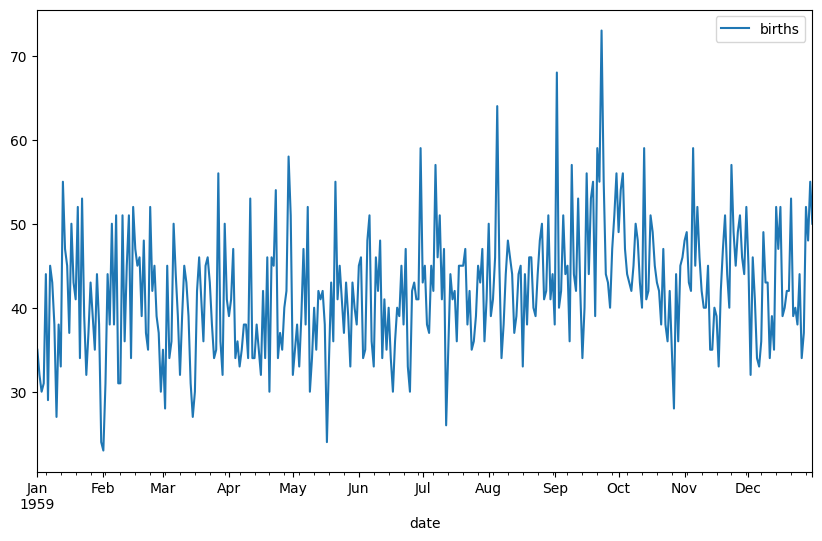

In [ ]:
df.plot(figsize=(10, 6))
plt.show()

**Checking for stationarity**

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(df['births'])
print("ADF statistics :%f" % result[0])
print("p-value: %f" % result[1])
print(result)

ADF statistics :-4.808291
p-value: 0.000052
(-4.808291253559765, 5.2434129901498554e-05, 6, 358, {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}, 2343.8290926464197)


In [ ]:
# Interpretation
adf_statistics = result[0]
p_value = result[1]

if p_value < 0.5:
    print("The time series is stationary (reject null Hypothesis)")

else:
    print("the time seris is not stationary (Fail to reject the null hypothsis)")

The time series is stationary (reject null Hypothesis)


# Decomposition

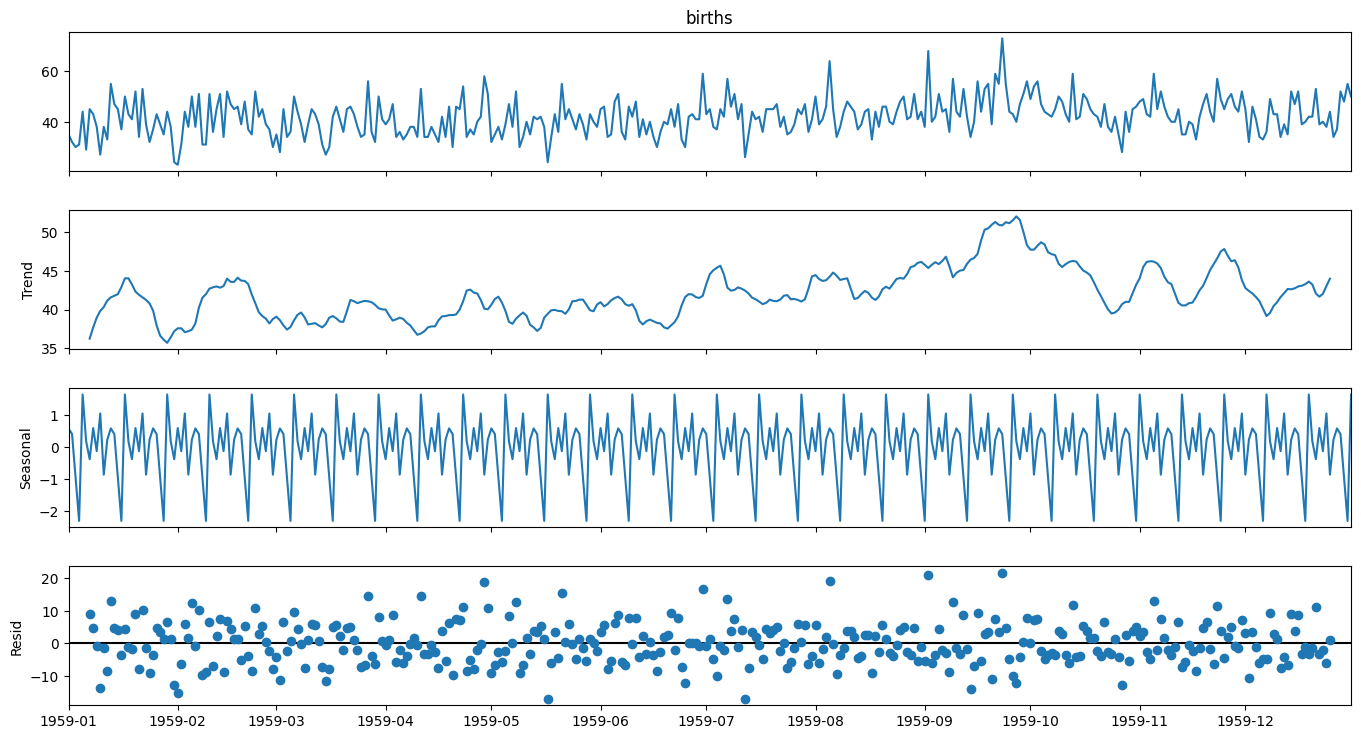

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Plot the decomposition-Additive model
result = seasonal_decompose(df['births'], model='additive', period=12)

fig = result.plot()
fig.set_size_inches(15, 8)
plt.show()

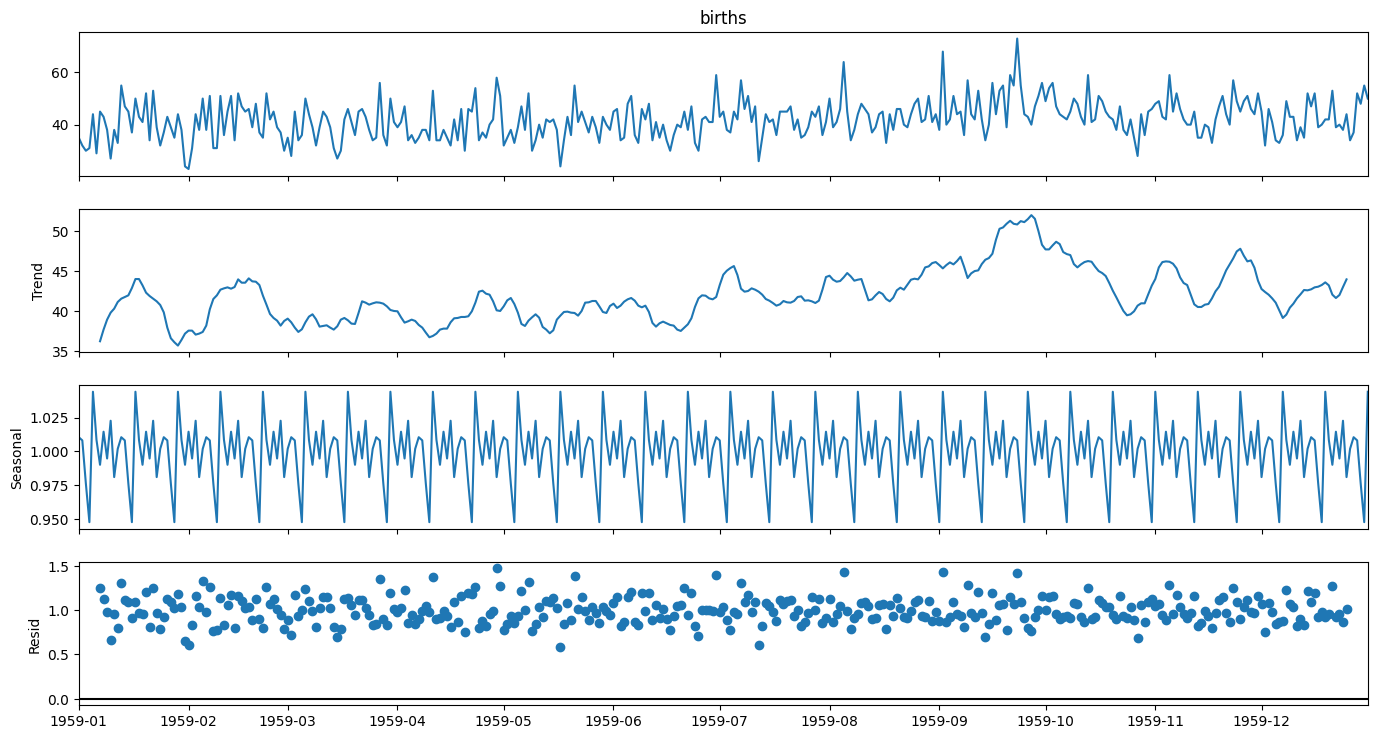

In [ ]:
#decompose the time series-Multiplicative model
result = seasonal_decompose(df['births'], model='multiplicative', period=12)

fig = result.plot()
fig.set_size_inches(15, 8)
plt.show()

# ACF and PACF Plot

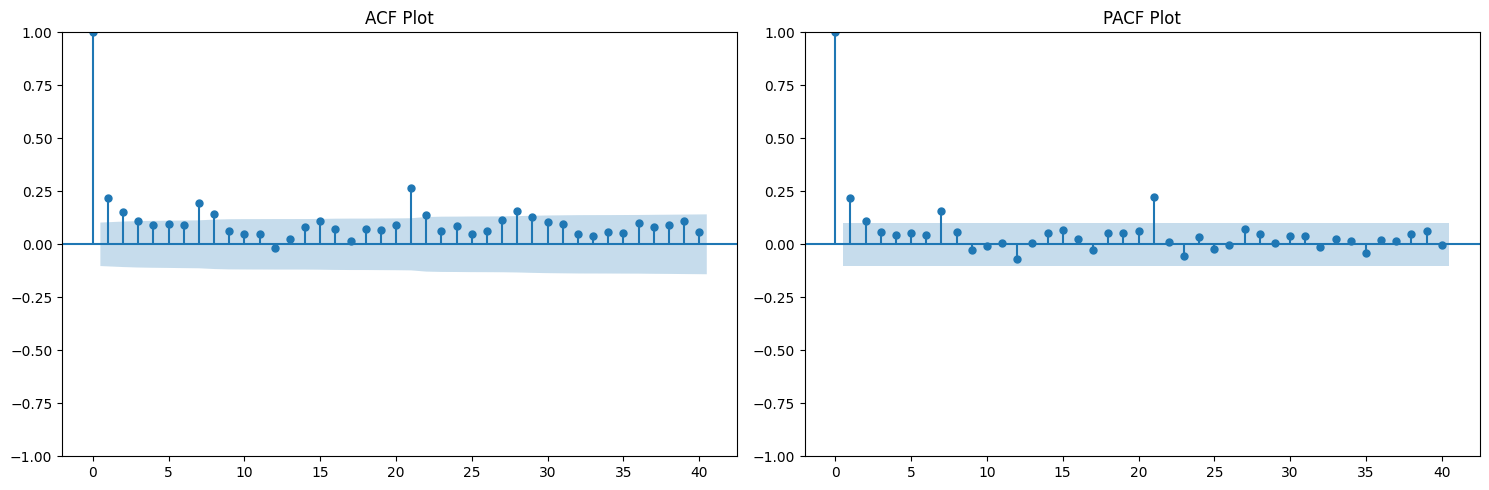

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Creating an ACF plot on the first subplot
plot_acf(df['births'], lags=40, ax=axes[0])
axes[0].set_title("ACF Plot")

# Creating a PACF plot on the second subplot
plot_pacf(df['births'], lags=40, ax=axes[1])
axes[1].set_title("PACF Plot")

# Display the plots
plt.tight_layout()
plt.show()


**Hyperparameter Tuning with Grid Search**

In [ ]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets for a seasonal period of 7
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(df['births'],
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param

        except:
            continue

print(f'Best SARIMA model: order={best_pdq}, seasonal_order={best_seasonal_pdq} with AIC={best_aic}')


Best SARIMA model: order=(0, 0, 2), seasonal_order=(0, 2, 2, 7) with AIC=2300.213226899833


In [ ]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_pdq = None

for param in pdq:
    try:
        mod = ARIMA(df['births'],
                    order=param)
        results = mod.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param

    except:
        continue

print(f'Best ARIMA model: order={best_pdq} with AIC={best_aic}')


Best ARIMA model: order=(1, 1, 1) with AIC=2459.0740779204125


# Modelling

Train-Test Split

In [ ]:
# Train test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

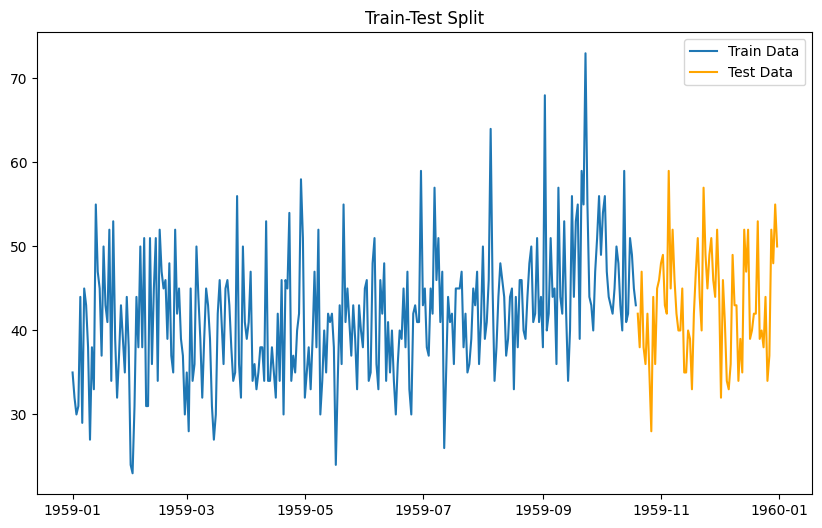

In [ ]:
# Plot the train-test split
plt.figure(figsize=(10, 6))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color='orange')
plt.title("Train-Test Split")
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARMA model (ARIMA with d=0)
model_arima = ARIMA(train,  order=(1, 1, 1))
arima = model_arima.fit()
print(arima.summary())


                               SARIMAX Results                                
Dep. Variable:                 births   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -985.074
Date:                Mon, 13 Jan 2025   AIC                           1976.149
Time:                        20:17:14   BIC                           1987.169
Sample:                    01-01-1959   HQIC                          1980.563
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0734      0.066      1.116      0.264      -0.056       0.202
ma.L1         -0.9563      0.021    -45.604      0.000      -0.997      -0.915
sigma2        50.6241      3.667     13.804      0.0

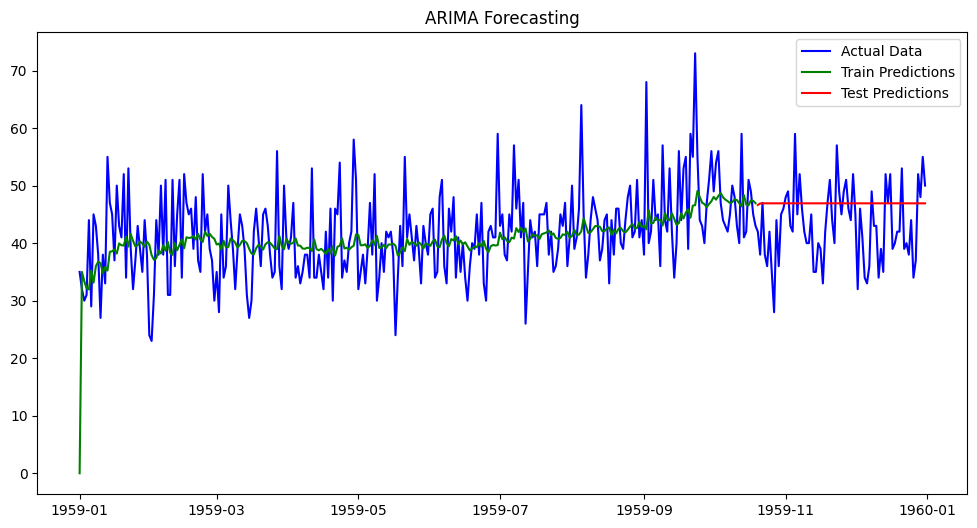

In [ ]:
# plot results for ARIMA
arima_train_predictions = arima.fittedvalues
arima_test_predictions = arima.forecast(len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df, label="Actual Data", color='blue')
plt.plot(train.index, arima_train_predictions, label="Train Predictions", color='green')
plt.plot(test.index, arima_test_predictions, label="Test Predictions", color='red')
plt.title("ARIMA Forecasting")
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX



# Fit the SARIMA model
model_sarima = SARIMAX (train, order=(0, 0, 2), seasonal_order=(0, 2, 2, 7) )
sarima = model_sarima.fit()
print(sarima.summary())


                                     SARIMAX Results                                     
Dep. Variable:                            births   No. Observations:                  292
Model:             SARIMAX(0, 0, 2)x(0, 2, 2, 7)   Log Likelihood                -969.532
Date:                           Mon, 13 Jan 2025   AIC                           1949.064
Time:                                   20:17:18   BIC                           1967.203
Sample:                               01-01-1959   HQIC                          1956.341
                                    - 10-19-1959                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0880      0.062      1.430      0.153      -0.033       0.209
ma.L2          0.0941      0.064      1.472

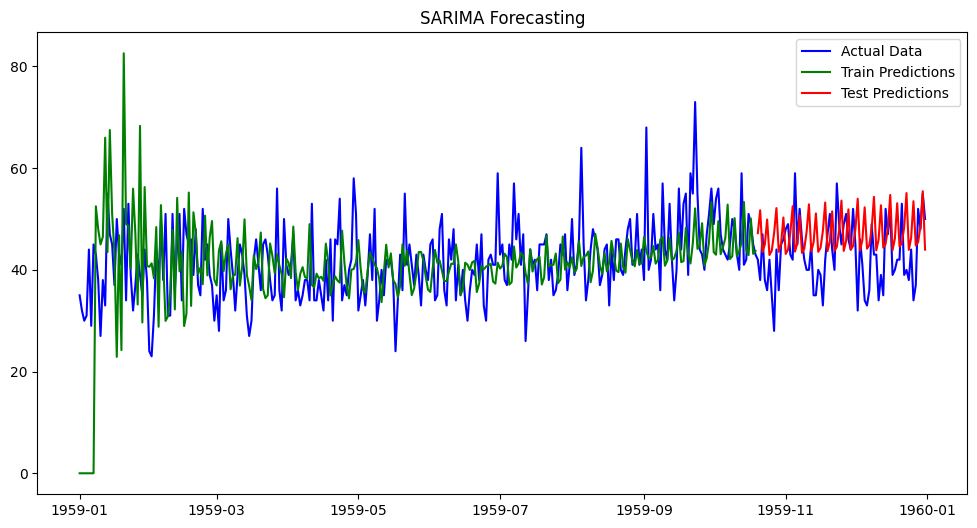

In [ ]:
sarima_train_predictions = sarima.fittedvalues
sarima_test_predictions = sarima.forecast(len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df, label="Actual Data", color='blue')
plt.plot(train.index, sarima_train_predictions, label="Train Predictions", color='green')
plt.plot(test.index, sarima_test_predictions, label="Test Predictions", color='red')
plt.title("SARIMA Forecasting")
plt.legend()
plt.show()

**Evaluation of Models**

In [ ]:
# Evaluate ARIMA
from sklearn.metrics import mean_absolute_error

arima_mae = mean_absolute_error(test, arima_test_predictions)
print(f"ARIMA MAE: {arima_mae:.2f}")

# Evaluate SARIMA
sarima_mae = mean_absolute_error(test, sarima_test_predictions)
print(f"SARIMA MAE: {sarima_mae:.2f}")


ARIMA MAE: 6.18
SARIMA MAE: 7.17
